### Description
- Patient visits who were transferred within 24 hours
    - ICUs to non-ICUs
    - Non-ICUs to ICUs
- Prediction differences between labels at time 0 and 24hr
- Differences between predicted values at time 0 and time 24 compared to their corresponding true labels
- Within the patient visits who were transferred:
    - More in depth about those with largest differences between the predictions at 2 time points
    - and how they are related to the differences in predicted values vs. true labels
    
Inputs:
- `1_4_cohort`
- prediction outputs for 3 labels using 1_4_cohort with light gbm

Outputs:
- `1_4_cohort_test_results` test cohort (admit year 2019 and 2020) with prediction results
- `1_4_cohort_diff_full_features` 318 vs 204 observations in test cohort (pred difference >= 0.3) with full features used for predictions

In [97]:
# install.packages('ROCR')

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘caTools’, ‘gplots’




In [160]:
library(caret) # import this before glmnet to avoid rlang version problem
library(data.table)
library(tidyverse)
library(lubridate)
library(Matrix)
library(glmnet)
library(bit64)
library(pROC)
library(ROCR)
library(rms)

In [68]:
# directories
datadir = "../../DataTD"
cohortdir = "../../OutputTD/1_cohort"
featuredir = "../../OutputTD/2_features"
# modeldir4 = "../../OutputTD/3_models/1_4_cohort"
modeldir4preadmit = "../../OutputTD/3_models/1_4_cohort_24hrpreadmit"

options(repr.matrix.max.rows=200, repr.matrix.max.cols=30)

In [31]:
# list.files(path="modeldir4", pattern="lightgbm_test_results.csv", full.names=TRUE, recursive=FALSE)
# dir(path="modeldir4") #pattern="*.csv")

In [32]:
# check folder and sub-folders
folder <- list.dirs(modeldir4) # this assumes being in the main folder, otherwise specify the path
folder
sub.folders <- folder[-1]  # comment this out if the main folder also contains the script
# script.paths <- paste(folder,"/","process.R", sep="")
# for (i in script.paths) {source(i)}

[1] "../../OutputTD/3_models/1_4_cohort"                        
[2] "../../OutputTD/3_models/1_4_cohort/death_24hr_max_label"   
[3] "../../OutputTD/3_models/1_4_cohort/death_24hr_recent_label"
[4] "../../OutputTD/3_models/1_4_cohort/first_label"

In [100]:
# sub-folders, check DIR!!!
sub.folders <- list.dirs(modeldir4preadmit)[-1]
sub.folders

[1] "../../OutputTD/3_models/1_4_cohort_24hrpreadmit/death_24hr_max_label"   
[2] "../../OutputTD/3_models/1_4_cohort_24hrpreadmit/death_24hr_recent_label"
[3] "../../OutputTD/3_models/1_4_cohort_24hrpreadmit/first_label"

In [101]:
cohort <- read.csv(file.path(cohortdir, '1_4_cohort.csv'))
nrow(cohort)
colnames(cohort)

[1] 43980

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"

### Patient visits year and those who transferred

In [102]:
cohort_test <-  cohort %>% mutate(admit_time = ymd_hms(admit_time)) %>% 
                    mutate(adm_year = year(admit_time),
                           transfer = ifelse(death_24hr_recent_label != first_label, 1, 0)) %>% 
                    filter(adm_year > 2018)
nrow(cohort_test)
table(cohort_test$adm_year)
sum(cohort_test$transfer)

[1] 12418


 2019  2020 
10115  2303 

[1] 805

In [103]:
summary(cohort$death_24hr_recent_label)
summary(cohort_test$death_24hr_recent_label)
summary(cohort_test$acute_to_critical_label_recent)
summary(cohort_test$critical_to_acute_label_recent)

sum(cohort_test$critical_to_acute_label_recent) #526 + 279 = 805 total transfers
sum(cohort_test$acute_to_critical_label_recent)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.09468 0.00000 1.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   0.104   0.000   1.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.02247 0.00000 1.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.04236 0.00000 1.00000 

[1] 526

[1] 279

### Patient visits with big differences in predictions at 2 time points

In [116]:
# for modeldir4preadmit, start at 49
for (f in sub.folders){
    print(f)
    out <- read.csv(paste0(f,"/","lightgbm_test_results.csv")) %>% select(pat_enc_csn_id_coded, predictions)
    cohort_test <- cohort_test %>% inner_join(out)
#     cohort_test[ , ncol(cohort_test) + 1] <- out$predictions
#     newcolname <- paste0("pred_", str_sub(f, start=-12))
    newcolname <- paste0("pred_", str_sub(f, start=49, end=-7))
    print(newcolname)
#     cohort_test <- cohort_test %>% rename(newcolname = predictions)
#     print(colnames(cohort_test))
    colnames(cohort_test)[ncol(cohort_test)] <- newcolname
}

[1] "../../OutputTD/3_models/1_4_cohort_24hrpreadmit/death_24hr_max_label"


Joining, by = "pat_enc_csn_id_coded"



[1] "pred_death_24hr_max"
[1] "../../OutputTD/3_models/1_4_cohort_24hrpreadmit/death_24hr_recent_label"


Joining, by = "pat_enc_csn_id_coded"



[1] "pred_death_24hr_recent"
[1] "../../OutputTD/3_models/1_4_cohort_24hrpreadmit/first_label"


Joining, by = "pat_enc_csn_id_coded"



[1] "pred_first"


In [115]:
colnames(cohort_test)

[1] "anon_id"                             "pat_enc_csn_id_coded"               
 [3] "inpatient_data_id_coded"             "admit_time"                         
 [5] "label_max24"                         "label_24hr_recent"                  
 [7] "admit_label"                         "has_admit_label"                    
 [9] "died_within_24hrs"                   "death_24hr_max_label"               
[11] "death_24hr_recent_label"             "first_label"                        
[13] "first_label_minutes_since_admit"     "acute_to_critical_label_recent"     
[15] "critical_to_acute_label_recent"      "acute_to_critical_label_max"        
[17] "critical_to_acute_label_max"         "adm_year"                           
[19] "transfer"                            "pred_24hrpreadmit/death_24hr_max"   
[21] "pred_24hrpreadmit/death_24hr_recent" "pred_24hrpreadmit/first"

In [117]:
pred3 <- gather(cohort_test, labels, predictions, pred_death_24hr_max:pred_first, factor_key=TRUE)
pred2 <- pred3 %>% filter(labels != 'pred_death_24hr_max')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



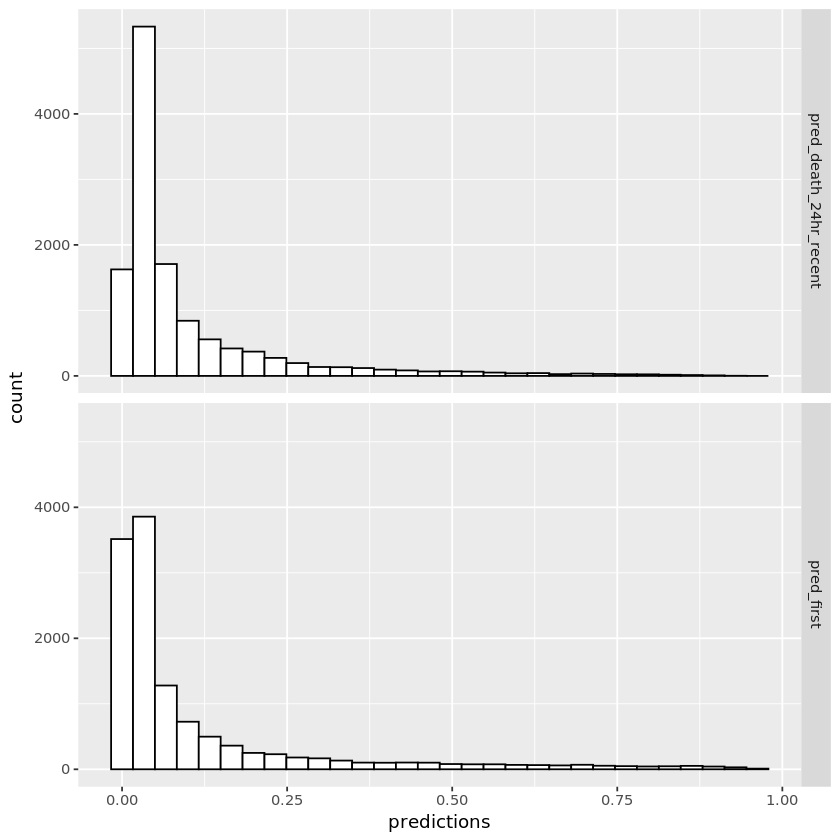

In [118]:
ggplot(pred2, aes(x = predictions)) +
  geom_histogram(fill = "white", colour = "black") +
  facet_grid(labels ~ .)

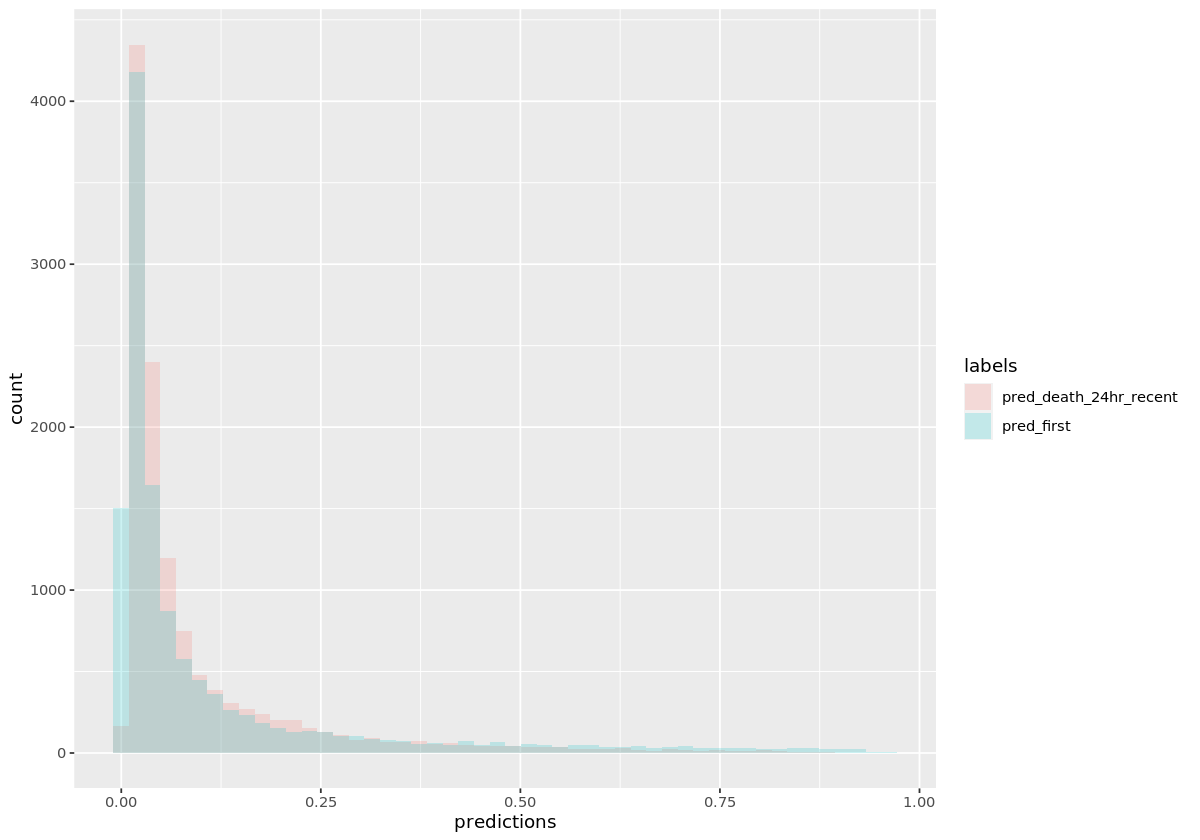

In [119]:
options(repr.plot.width=10, repr.plot.height=7)

ggplot(pred2, aes(x = predictions, fill = labels)) +         
  geom_histogram(position = "identity", alpha = 0.2, bins = 50)

In [120]:
cohort_test <- cohort_test %>% mutate(diff0_24 = round(pred_first - pred_death_24hr_recent, 2),
                                      diff0_True = round(pred_first - first_label, 2),
                                      diff24_True = round(pred_death_24hr_recent - death_24hr_max_label, 2)) %>%
               mutate(abs_diff0_24 = round(abs(diff0_24), 1))

In [121]:
nrow(cohort_test)
colnames(cohort_test)
summary(cohort_test)

[1] 12418

[1] "anon_id"                             "pat_enc_csn_id_coded"               
 [3] "inpatient_data_id_coded"             "admit_time"                         
 [5] "label_max24"                         "label_24hr_recent"                  
 [7] "admit_label"                         "has_admit_label"                    
 [9] "died_within_24hrs"                   "death_24hr_max_label"               
[11] "death_24hr_recent_label"             "first_label"                        
[13] "first_label_minutes_since_admit"     "acute_to_critical_label_recent"     
[15] "critical_to_acute_label_recent"      "acute_to_critical_label_max"        
[17] "critical_to_acute_label_max"         "adm_year"                           
[19] "transfer"                            "pred_24hrpreadmit/death_24hr_max"   
[21] "pred_24hrpreadmit/death_24hr_recent" "pred_24hrpreadmit/first"            
[23] "pred_death_24hr_max"                 "pred_death_24hr_recent"             
[25] "pred_first"                          "diff0_24"                           
[27] "diff0_True"                          "diff24_True"                        
[29] "abs_diff0_24"

   anon_id          pat_enc_csn_id_coded inpatient_data_id_coded
 Length:12418       Min.   :1.313e+11    Min.   :33212811       
 Class :character   1st Qu.:1.313e+11    1st Qu.:35996148       
 Mode  :character   Median :1.313e+11    Median :39994636       
                    Mean   :1.313e+11    Mean   :40003546       
                    3rd Qu.:1.313e+11    3rd Qu.:43886508       
                    Max.   :1.313e+11    Max.   :48026130       
                                                                
   admit_time                   label_max24     label_24hr_recent
 Min.   :2019-01-01 00:03:00   Min.   :0.0000   Min.   :0.0000   
 1st Qu.:2019-04-13 00:01:30   1st Qu.:0.0000   1st Qu.:0.0000   
 Median :2019-08-04 21:50:30   Median :0.0000   Median :0.0000   
 Mean   :2019-08-08 00:19:00   Mean   :0.1512   Mean   :0.1033   
 3rd Qu.:2019-12-01 06:24:15   3rd Qu.:0.0000   3rd Qu.:0.0000   
 Max.   :2020-03-31 07:00:00   Max.   :1.0000   Max.   :1.0000   
                  

5%   10%   20%   30%   40%   50%   60%   70%   80%   90%   95% 
-0.06 -0.04 -0.02 -0.01 -0.01  0.00  0.00  0.00  0.03  0.09  0.18

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.47000 -0.01000  0.00000  0.01416  0.01000  0.71000 

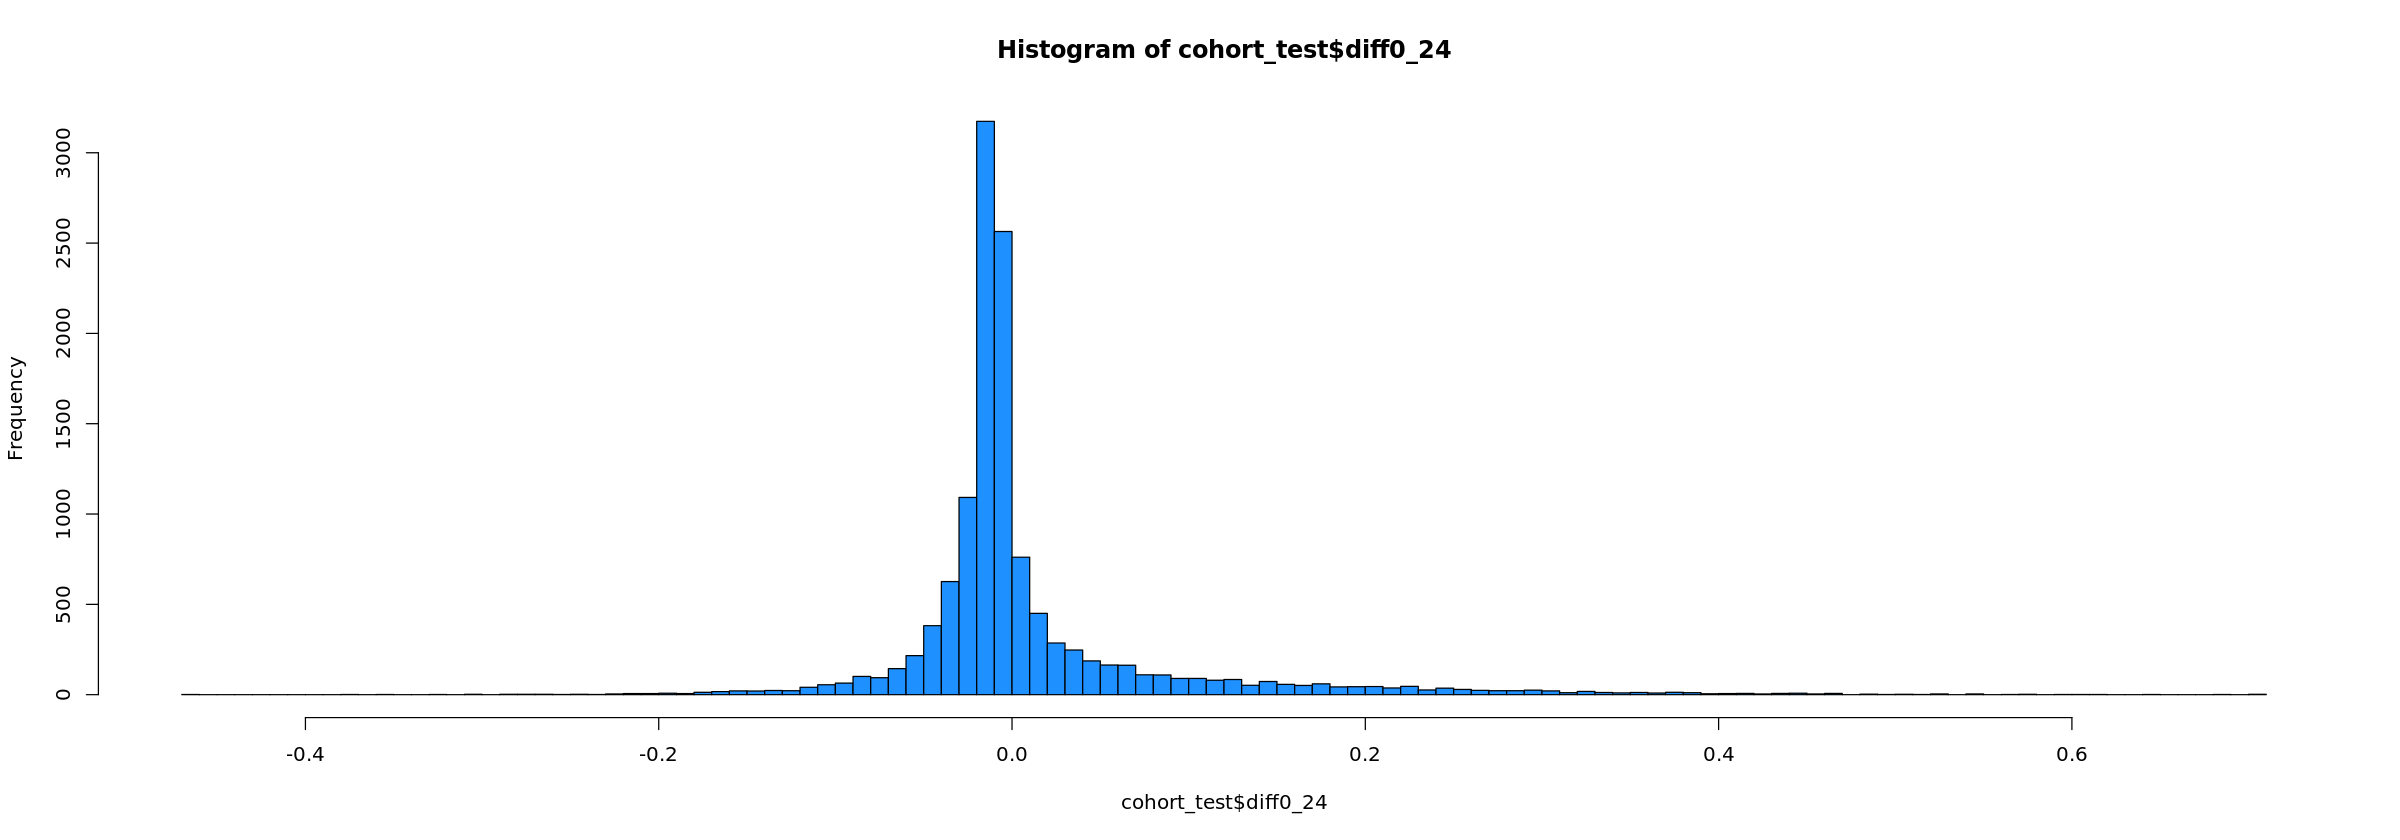

In [122]:
options(repr.plot.width=20, repr.plot.height=7)

quantile(cohort_test$diff0_24, c(.05, .1, .2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95)) 
summary(cohort_test$diff0_24)
hist(cohort_test$diff0_24, col='dodgerblue', breaks=100)

In [123]:
# diff <- cohort_test %>% arrange(-abs_diff0_24) %>% 
#         mutate(rec = 1, pround = round(abs_diff0_24, 1)) %>% 
#         group_by(pround) %>% mutate(psum = sum(rec)) %>% 
#         distinct(pround, psum) %>%
#         filter(pround > 0) #%>% mutate(cumsize = cumsum(psum)) # %>% select(-rec)

# diff$cumsize <- cumsum(diff$psum)

nrow(cohort_test %>% filter(abs_diff0_24 >= 0.3))
diff <- cohort_test %>% 
            group_by(abs_diff0_24) %>% summarise(count = n()) %>% arrange(-abs_diff0_24) %>% 
            mutate(cum_count = cumsum(count), cumperc = round(100*cum_count/nrow(cohort_test), 2)) 

diff

[1] 324

abs_diff0_24,count,cum_count,cumperc
<dbl>,<int>,<int>,<dbl>
0.7,4,4,0.03
0.6,10,14,0.11
0.5,23,37,0.30
0.4,83,120,0.97
0.3,204,324,2.61
0.2,509,833,6.71
0.1,1600,2433,19.59
0.0,9985,12418,100.00


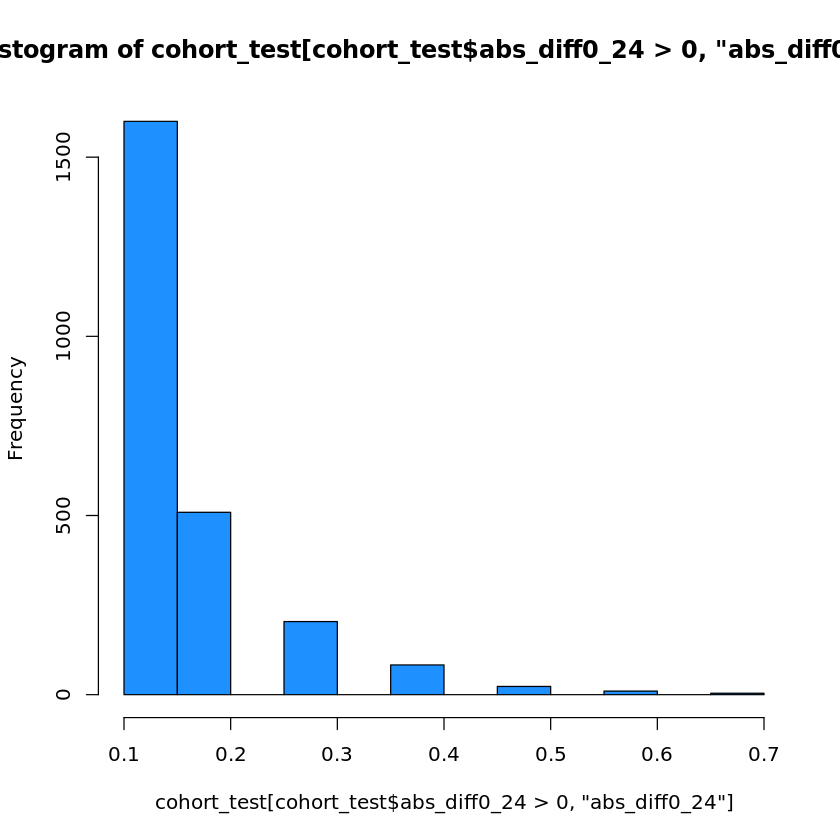

In [124]:
# threshold and size plot
options(repr.plot.width=7, repr.plot.height=7)

# absolute count
hist(cohort_test[cohort_test$abs_diff0_24 > 0, 'abs_diff0_24'], col='dodgerblue')

In [125]:
# this remained the same after updating coh4 to remove obs with labs and vitals > 24hr pre admit
diff[diff$abs_diff0_24 > 0.1,]$cum_count

[1]   4  14  37 120 324 833

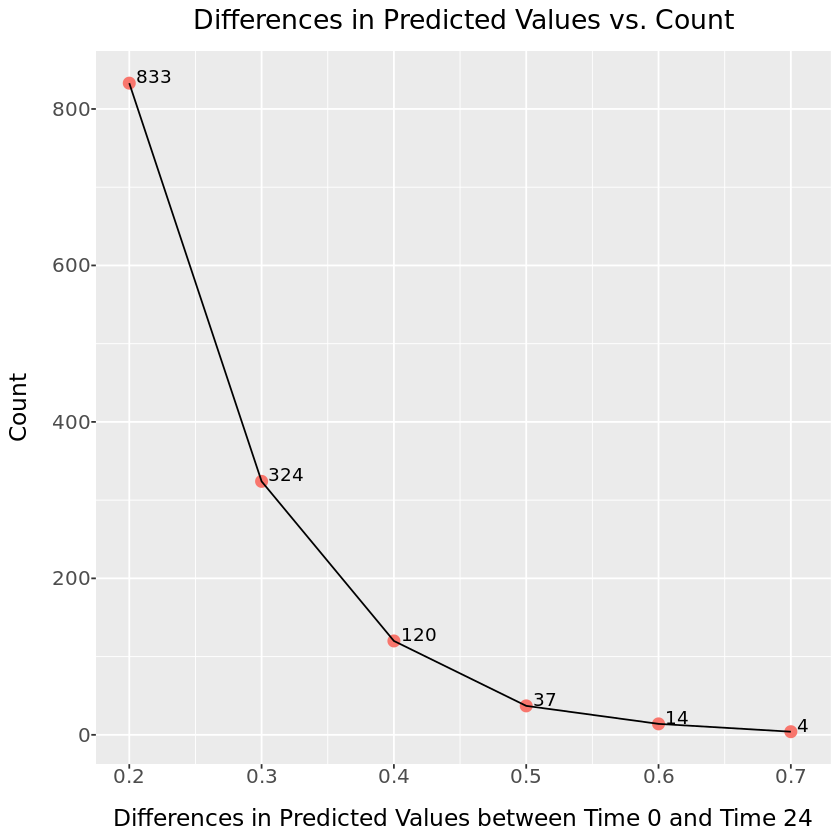

In [126]:
# cummulative count
ggplot(diff[diff$abs_diff0_24 > 0.1, ], aes(x=abs_diff0_24, y=cum_count)) + 
    geom_point(color = "#F8766D", size = 3) + geom_line() +
    geom_text(label=diff[diff$abs_diff0_24 > 0.1, ]$cum_count, hjust = 0, nudge_x = 0.005, vjust =0) + 
    labs(x="Differences in Predicted Values between Time 0 and Time 24", y="Count", 
               title = "Differences in Predicted Values vs. Count") +
    theme(axis.text=element_text(size=12),
          axis.text.x = element_text(margin=margin(0, 0, 10, 0)), #color = "red", 
          axis.text.y = element_text(margin=margin(0, 0, 0, 10)), #color = "red",
          plot.title = element_text(size=16, hjust=0.5, margin=margin(0, 0, 10, 0)),
          axis.title=element_text(size=14),
          legend.key.size = unit(1, "cm"))#, face="bold"
# ggsave("Figure - Count of Differences.png", width = 14, height = 7, dpi = 1200) 

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



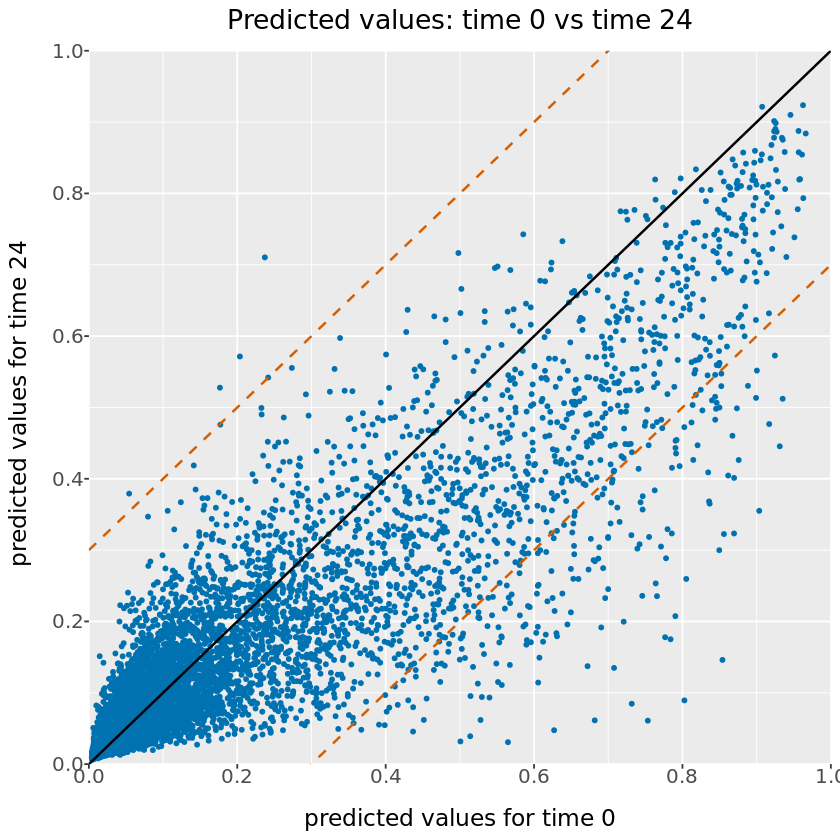

In [127]:
options(repr.plot.width=7, repr.plot.height=7)

ggplot(cohort_test, aes(x=pred_first, y=pred_death_24hr_recent)) + 
    geom_point(color = "#0072B2", size = 1) + xlim(0,1) + ylim(0,1) +
    geom_abline(intercept = 0, slope = 1, size = 0.7) +
    geom_abline(intercept = 0.3, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
    geom_abline(intercept = -0.3, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
    scale_x_continuous(name = "predicted values for time 0", expand = c(0, 0), limits=c(0, 1), 
                       breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) + 
    scale_y_continuous(name = " predicted values for time 24", expand = c(0, 0), limits=c(0, 1), 
                       breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) +
    theme(axis.text=element_text(size=12),
          axis.text.x = element_text(margin=margin(0, 0, 10, 0)),
          axis.text.y = element_text(margin=margin(0, 0, 0, 10)),
          plot.title = element_text(size=16, hjust=0.5, margin=margin(0, 0, 10, 0)),
          axis.title=element_text(size=14)) +
     labs(title = "Predicted values: time 0 vs time 24")


In [128]:
write.csv(cohort_test, file.path(modeldir4preadmit, "1_4_cohort_test_results.csv"), row.names=FALSE)

### Get all features used for prediction for the test cohort

In [8]:
orders5 <- read.csv(file.path(datadir, 'coh5_order_code_counts.csv'))
nrow(orders5) # should have 5730678

[1] 5730678

In [129]:
orders4 <- read.csv(file.path(datadir, 'coh4_order_code_counts.csv')) %>% 
            mutate(admit_time = ymd_hms(admit_time),
                   feature_type = ifelse(str_detect(feature_type, "Microbiology"), "Microbiology", feature_type))
nrow(orders4) # 6086852

[1] 6086852

In [130]:
values <- read.csv(file.path(featuredir, '2_7_coh4_feature_values.csv')) %>% 
                    mutate(admit_time = ymd_hms(admit_time), time = ymd_hms(time),
                           hr_before_admit = round(as.numeric(difftime(admit_time, time, unit="hours")), 1))
nrow(values) #3085046

[1] 3085046

In [131]:
colnames(orders4)
colnames(values)
colnames(cohort_test)
nrow(cohort_test)

[1] "anon_id"              "pat_enc_csn_id_coded" "admit_time"          
[4] "feature_type"         "features"             "values"

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time"              "first_label"            
 [5] "death_24hr_recent_label" "death_24hr_max_label"   
 [7] "feature_type"            "features"               
 [9] "values"                  "time"                   
[11] "hr_before_admit"

[1] "anon_id"                             "pat_enc_csn_id_coded"               
 [3] "inpatient_data_id_coded"             "admit_time"                         
 [5] "label_max24"                         "label_24hr_recent"                  
 [7] "admit_label"                         "has_admit_label"                    
 [9] "died_within_24hrs"                   "death_24hr_max_label"               
[11] "death_24hr_recent_label"             "first_label"                        
[13] "first_label_minutes_since_admit"     "acute_to_critical_label_recent"     
[15] "critical_to_acute_label_recent"      "acute_to_critical_label_max"        
[17] "critical_to_acute_label_max"         "adm_year"                           
[19] "transfer"                            "pred_24hrpreadmit/death_24hr_max"   
[21] "pred_24hrpreadmit/death_24hr_recent" "pred_24hrpreadmit/first"            
[23] "pred_death_24hr_max"                 "pred_death_24hr_recent"             
[25] "pred_first"                          "diff0_24"                           
[27] "diff0_True"                          "diff24_True"                        
[29] "abs_diff0_24"

[1] 12418

In [132]:
nrow(values %>% filter(feature_type %in% c('vitals', 'labs'), hr_before_admit > 24))
nrow(values)
values <- values %>% filter(hr_before_admit <= 24 | is.na(hr_before_admit))
nrow(values)

[1] 40070

[1] 3085046

[1] 3044976

In [133]:
3085046 - 40070

[1] 3044976

In [134]:
cohort_diff <- cohort_test %>% select(anon_id, pat_enc_csn_id_coded, admit_time, 
                                      first_label, death_24hr_recent_label, death_24hr_max_label,
                                      pred_first, pred_death_24hr_recent, abs_diff0_24, diff0_True, diff24_True) %>% 
                    filter(abs_diff0_24 >= 0.3)

In [135]:
diff_cohort_orders <- left_join(cohort_diff, orders4)
diff_cohort_values <- left_join(cohort_diff, values) 
length(unique(diff_cohort_orders$pat_enc_csn_id_coded))
length(unique(diff_cohort_values$pat_enc_csn_id_coded))

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time")

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time", "first_label", "death_24hr_recent_label", "death_24hr_max_label")



[1] 324

[1] 324

In [136]:
nrow(diff_cohort_orders)
nrow(diff_cohort_values) # only 1 less than before 
diff_cohort_orders %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)
diff_cohort_values %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)

[1] 38241

[1] 31093

feature_type,n
<chr>,<int>
Microbiology,195
Procedures,491
Imaging,1938
Lab,6106
Meds,11867
Diagnosis,17644


feature_type,n
<chr>,<int>
demo,5508
labs,12497
vitals,13088


In [137]:
diff_cohort_full_features <- full_join(diff_cohort_orders, diff_cohort_values) 
nrow(diff_cohort_full_features) # only 1 less
nrow(diff_cohort_orders) + nrow(diff_cohort_values)
length(unique(diff_cohort_full_features$pat_enc_csn_id_coded))
diff_cohort_full_features %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time", "first_label", "death_24hr_recent_label", "death_24hr_max_label", "pred_first", "pred_death_24hr_recent", "abs_diff0_24", "diff0_True", "diff24_True", "feature_type", "features", "values")



[1] 69334

[1] 69334

[1] 324

feature_type,n
<chr>,<int>
Microbiology,195
Procedures,491
Imaging,1938
demo,5508
Lab,6106
Meds,11867
labs,12497
vitals,13088
Diagnosis,17644


In [138]:
write.csv(diff_cohort_full_features, file.path(modeldir4preadmit, "1_4_cohort_diff_full_features.csv"), row.names=FALSE)

### Patient visits predictions vs. truth


In [139]:
summary(cohort_test$diff0_True)
summary(cohort_test$diff24_True)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.99000  0.01000  0.02000 -0.01085  0.06000  0.94000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.99000  0.02000  0.03000 -0.05305  0.06000  0.76000 

In [140]:
diff3 <- gather(cohort_test, diffs, values, diff0_24:diff24_True, factor_key=TRUE)
diff2 <- diff3 %>% filter(diffs != 'diff0_24')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



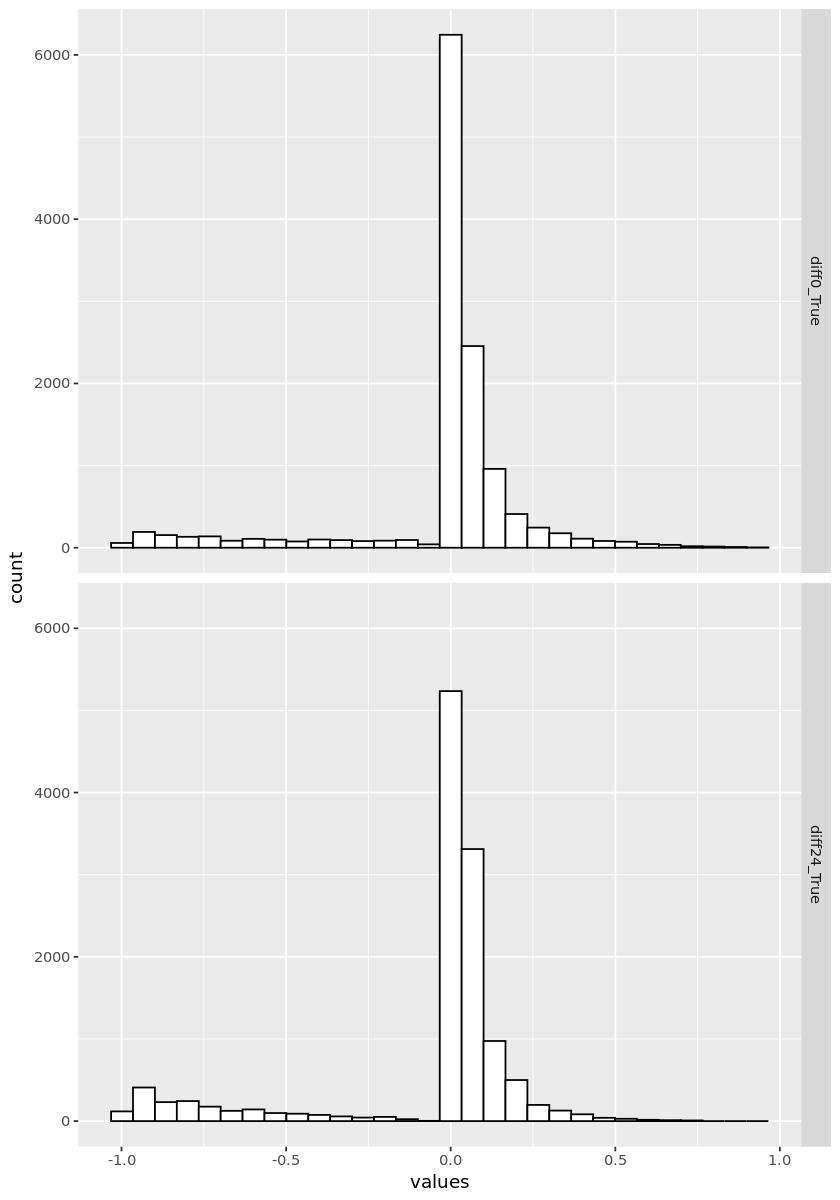

In [141]:
options(repr.plot.width=7, repr.plot.height=10)

ggplot(diff2, aes(x = values)) +
  geom_histogram(fill = "white", colour = "black") +
  facet_grid(diffs ~ .)

### 

### Check most difference first (33 vs 37)
- 0.7 or more: 3 vs 4
- 0.6 or more: 11 vs 10
- 0.5 or more: 19 vs 23

In [142]:
diff

abs_diff0_24,count,cum_count,cumperc
<dbl>,<int>,<int>,<dbl>
0.7,4,4,0.03
0.6,10,14,0.11
0.5,23,37,0.30
0.4,83,120,0.97
0.3,204,324,2.61
0.2,509,833,6.71
0.1,1600,2433,19.59
0.0,9985,12418,100.00


### Get the full data for the cohort for exploratory analysis

In [143]:
cohort <- cohort %>% mutate(admit_time = ymd_hms(admit_time)) 

In [144]:
cohort_orders <- inner_join(cohort, orders4)
cohort_values <- inner_join(cohort, values)

cohort_orders %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)
cohort_values %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)

length(unique(cohort$pat_enc_csn_id_coded))

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time")

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time", "death_24hr_max_label", "death_24hr_recent_label", "first_label")



feature_type,n
<chr>,<int>
Microbiology,39017
Procedures,51696
Imaging,299944
Lab,993484
Meds,1868195
Diagnosis,2834516


feature_type,n
<chr>,<int>
demo,747660
vitals,958312
labs,1339004


[1] 43980

In [145]:
colnames(cohort_orders)
colnames(cohort_values)

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "feature_type"                   
[19] "features"                        "values"

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "feature_type"                   
[19] "features"                        "values"                         
[21] "time"                            "hr_before_admit"

In [146]:
head(cohort_orders, 1)
head(cohort_values, 1)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,feature_type,features,values
,<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>
1,JCd97296,1.31176e+11,18290644,2016-02-06 22:31:00,0,0,NA,0,0,0,0,0,1325,0,0,0,0,Lab,CBC WITH DIFFERENTIAL,2


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,feature_type,features,values,time,hr_before_admit
,<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dttm>,<dbl>
1,JCd97296,1.31176e+11,18290644,2016-02-06 22:31:00,0,0,NA,0,0,0,0,0,1325,0,0,0,0,demo,ESI_i,2,NA,NA


In [147]:
cohort_full <- bind_rows(cohort_orders, cohort_values)
nrow(cohort_full) # 9131828
nrow(cohort_orders) + nrow(cohort_values)
length(unique(cohort_full$pat_enc_csn_id_coded))
cohort_full %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)

[1] 9131828

[1] 9131828

[1] 43980

feature_type,n
<chr>,<int>
Microbiology,39017
Procedures,51696
Imaging,299944
demo,747660
vitals,958312
Lab,993484
labs,1339004
Meds,1868195
Diagnosis,2834516


In [148]:
head(cohort_full, 1)
tail(cohort_full, 1)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,feature_type,features,values,time,hr_before_admit
,<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dttm>,<dbl>
1,JCd97296,1.31176e+11,18290644,2016-02-06 22:31:00,0,0,NA,0,0,0,0,0,1325,0,0,0,0,Lab,CBC WITH DIFFERENTIAL,2,NA,NA


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,feature_type,features,values,time,hr_before_admit
,<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dttm>,<dbl>
9131828,JCdeb097,131261813349,33702913,2019-02-06 12:21:00,0,0,0,1,0,0,0,0,0,0,0,0,0,labs,O2sat_v,82,2019-02-06 08:46:00,3.6


In [149]:
write.csv(cohort_full, file.path(featuredir, "1_4_cohort_24hrpreadmit_full_features.csv"), row.names=FALSE)

In [150]:
cohort_full %>% filter(is.na(feature_type)) # if join, will have some as 10 patients had no queried order counts

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,feature_type,features,values,time,hr_before_admit
<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dttm>,<dbl>


In [157]:
cohort_full %>% filter(first_label == death_24hr_recent_label) %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
cohort_full %>% filter(first_label == death_24hr_recent_label) %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% top_n(10)

feature_type,n
<chr>,<int>
Diagnosis,2686793
Meds,1766920
labs,1254132
Lab,938854
vitals,881895
demo,705177
Imaging,283278
Procedures,48607
Microbiology,36980


Selecting by n



features,n
<chr>,<int>
Pulse,197574
RR,186108
SBP,183919
DBP,183885
Temp,130409
Glucose,47200
Hct,41759
K,41729
Hgb,41711


In [158]:
cohort_full %>% filter(first_label != death_24hr_recent_label) %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
cohort_full %>% filter(first_label != death_24hr_recent_label) %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% top_n(10)

feature_type,n
<chr>,<int>
Diagnosis,147723
Meds,101275
labs,84872
vitals,76417
Lab,54630
demo,42483
Imaging,16666
Procedures,3089
Microbiology,2037


Selecting by n



features,n
<chr>,<int>
Pulse,17411
RR,17265
SBP,16892
DBP,16891
Temp,7958
Glucose,3576
K,2947
Na,2924
Hgb,2921


In [159]:
cohort_full %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
cohort_full %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% top_n(10)

feature_type,n
<chr>,<int>
Diagnosis,2834516
Meds,1868195
labs,1339004
Lab,993484
vitals,958312
demo,747660
Imaging,299944
Procedures,51696
Microbiology,39017


Selecting by n



features,n
<chr>,<int>
Pulse,214985
RR,203373
SBP,200811
DBP,200776
Temp,138367
Glucose,50776
Hct,44679
K,44676
Hgb,44632


In [154]:
coh_vsglu <- cohort_full %>% filter(feature_type=='vitals' | features=="Glucose") %>%
                    mutate(pat_enc_csn_id_coded = factor(pat_enc_csn_id_coded),
                           features = factor(features)) %>%
                    group_by(pat_enc_csn_id_coded, features, hr_before_admit) %>%
                    summarise(values=mean(values, na.rm=TRUE))
                    
coh_vsglu %>% group_by(features) %>% summarise(n=n())
head(coh_vsglu)

# before updating to limit vitals and labs values within 24hrs prior to admit,
# 131242313490 had a very weird obs with time of about 16 years before admit_time
summary(coh_vsglu$hr_before_admit)

`summarise()` has grouped output by 'pat_enc_csn_id_coded', 'features'. You can override using the `.groups` argument.



features,n
<fct>,<int>
DBP,192564
Glucose,50163
Pulse,203398
RR,193024
SBP,192594
Temp,77424


pat_enc_csn_id_coded,features,hr_before_admit,values
<fct>,<fct>,<dbl>,<dbl>
131062667066,DBP,4.0,48
131062667066,DBP,5.0,56
131062667066,DBP,5.5,52
131062667066,DBP,6.0,47
131062667066,DBP,6.3,43
131062667066,DBP,6.6,33


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.200   2.600   3.629   4.600  24.000 

In [155]:
colnames(cohort_full)

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "feature_type"                   
[19] "features"                        "values"                         
[21] "time"                            "hr_before_admit"

In [ ]:
# coh_sample <- sample_n(cohort_full, 10000)

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



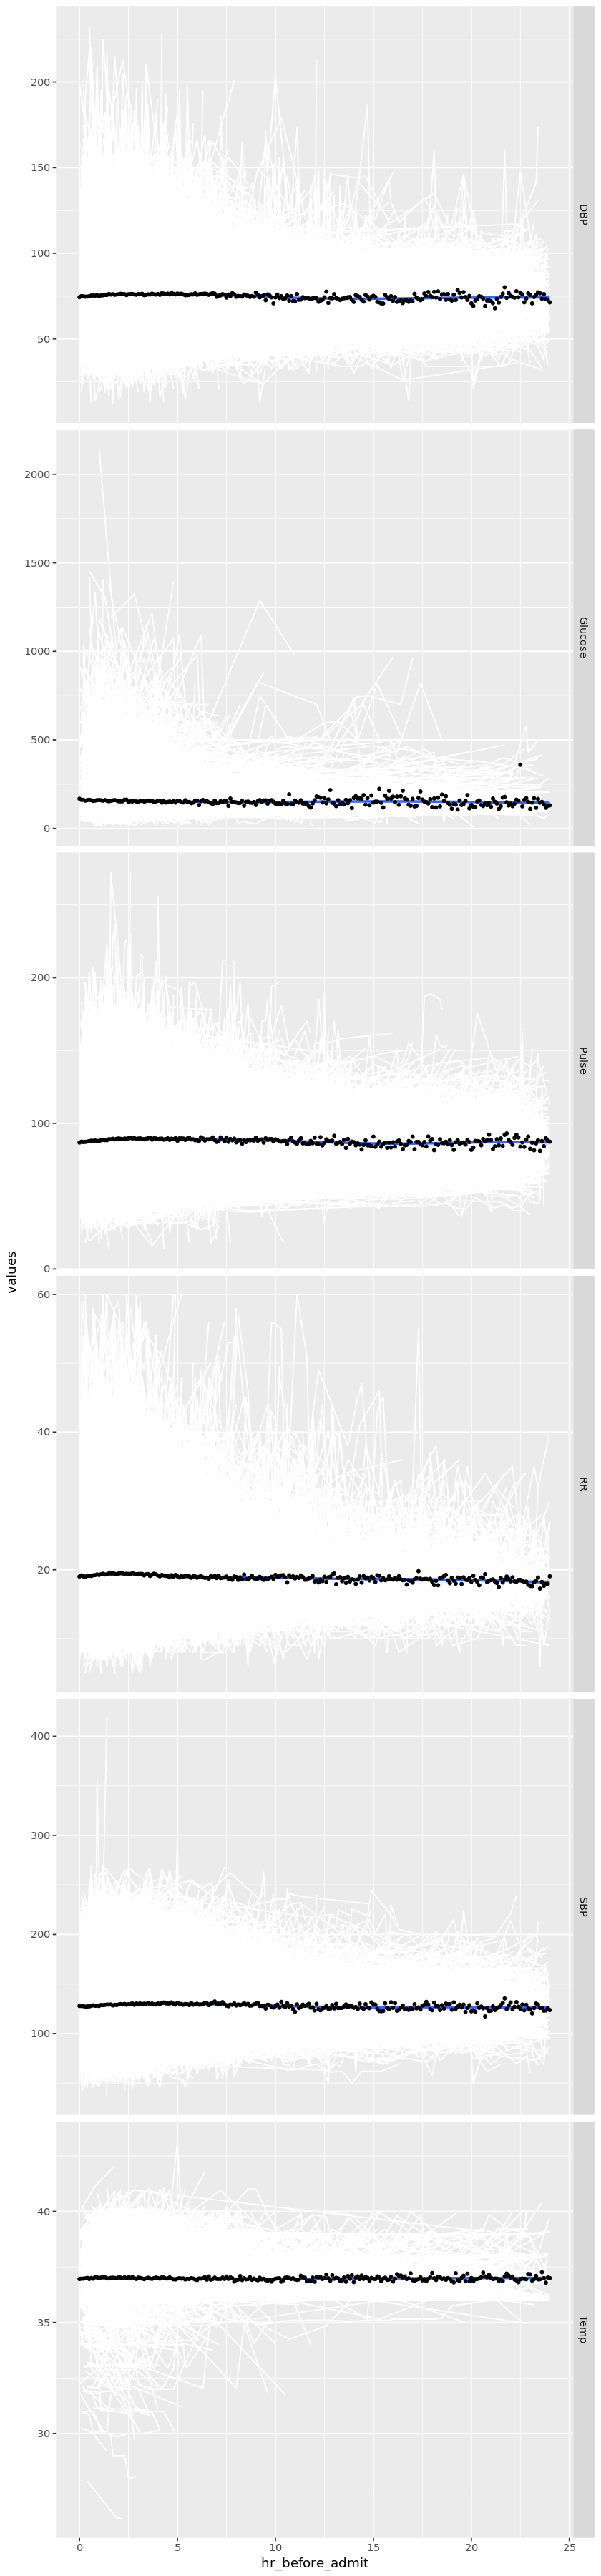

In [156]:
# this one takes a long time and the trends are all mostly flat
# although we see more fluctiation near admit_time
options(repr.plot.width=7, repr.plot.height=30)

coh_vsglu12 <- coh_vsglu %>% filter(hr_before_admit <= 200)
p <- ggplot(data = coh_vsglu12, aes(x = hr_before_admit, y = values, group = pat_enc_csn_id_coded)) + facet_grid(features ~ ., scales="free")

# use group 1 as for the whole data NOT per csn: so the smooth is not calculated separately for each csn
p + geom_line(color="white") + stat_smooth(aes(group = 1)) + stat_summary(aes(group = 1), geom = "point", size=1, fun.y = mean)

### Check AUC and PRC

[1] 0.8769369

[1] 0.645035

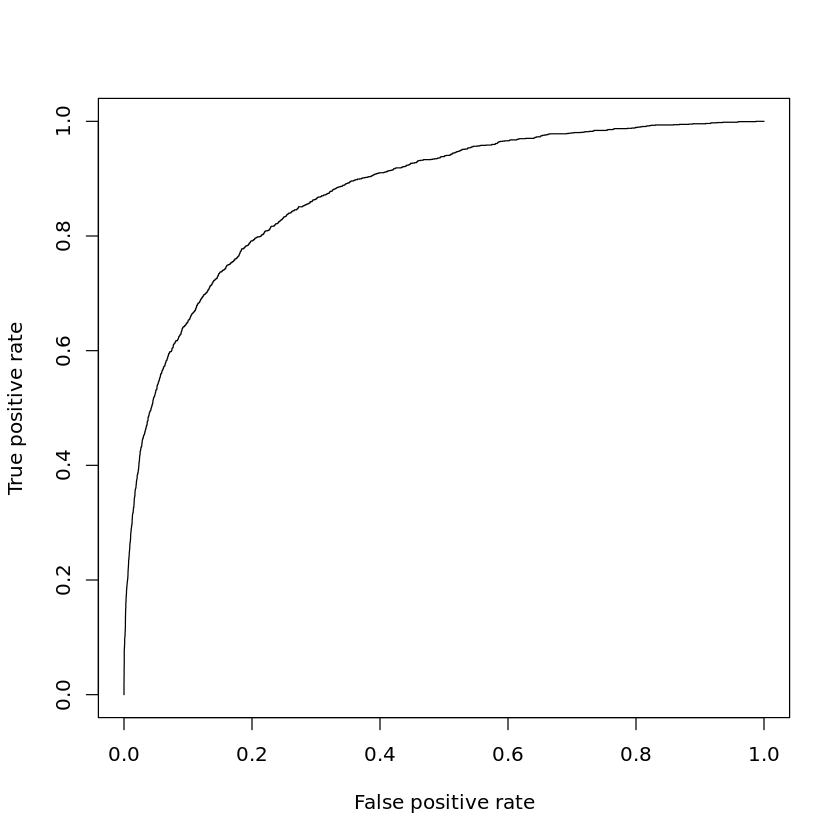

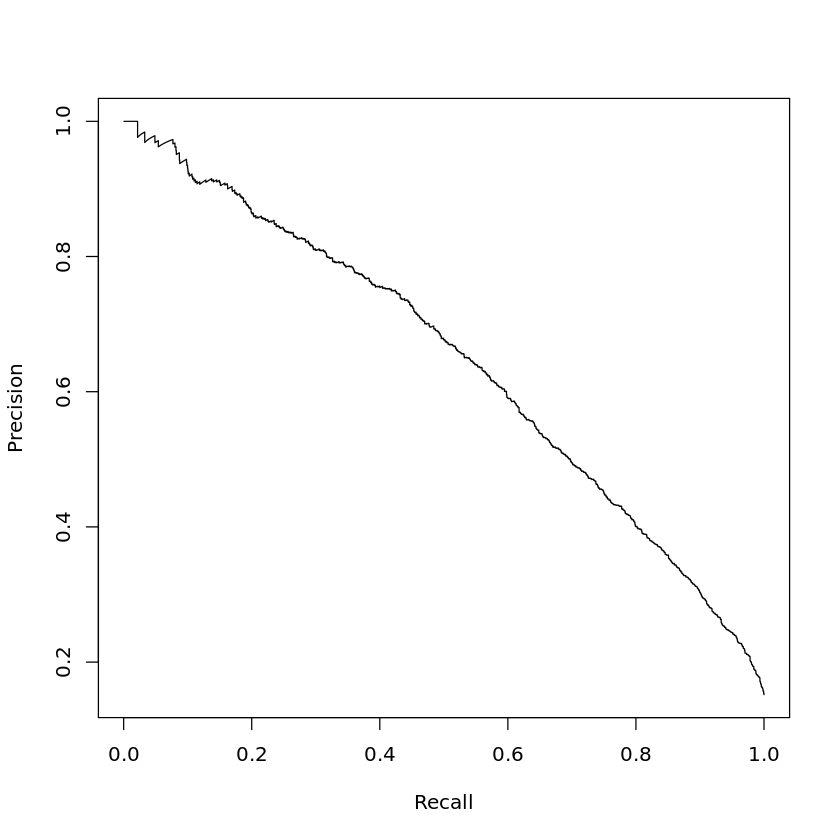

In [161]:
# get performance metrics AUC and PRC, highest level of care
options(repr.plot.width=7, repr.plot.height=7)

# pred_rocr = ROCR::prediction(cohort_test$pred_death_24hr_recent, cohort_test$death_24hr_recent_label)
pred_rocr = ROCR::prediction(cohort_test$pred_death_24hr_max, cohort_test$death_24hr_max_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc #0.875995437857203 and 0.64255115231513 for 1_4coh

plot(ROC.perf)
plot(PRC.perf)

[1] 0.8519265

[1] 0.4850166

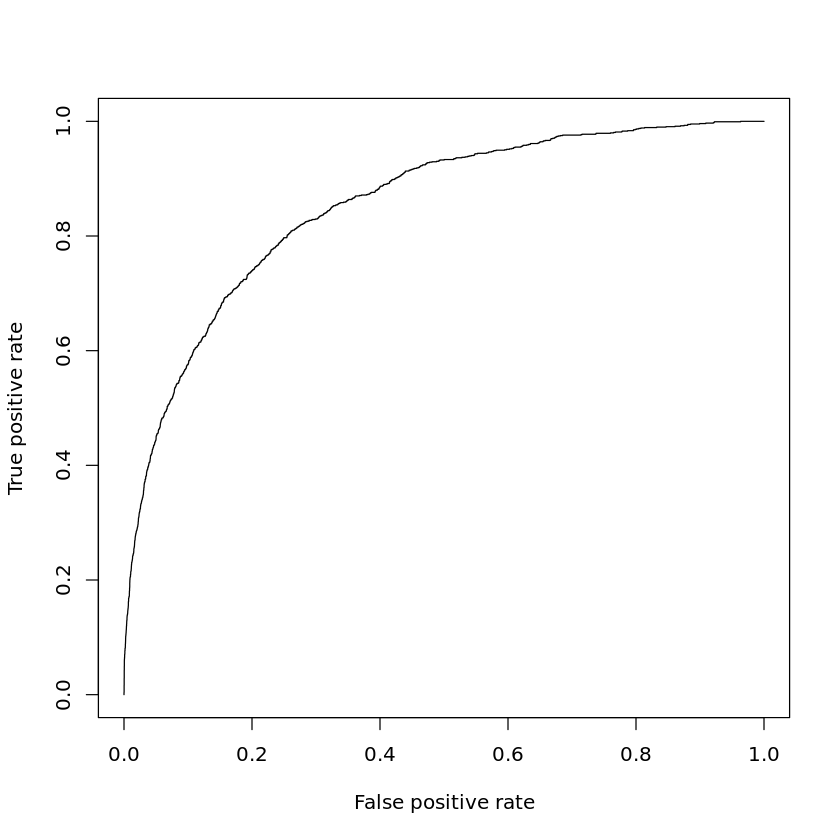

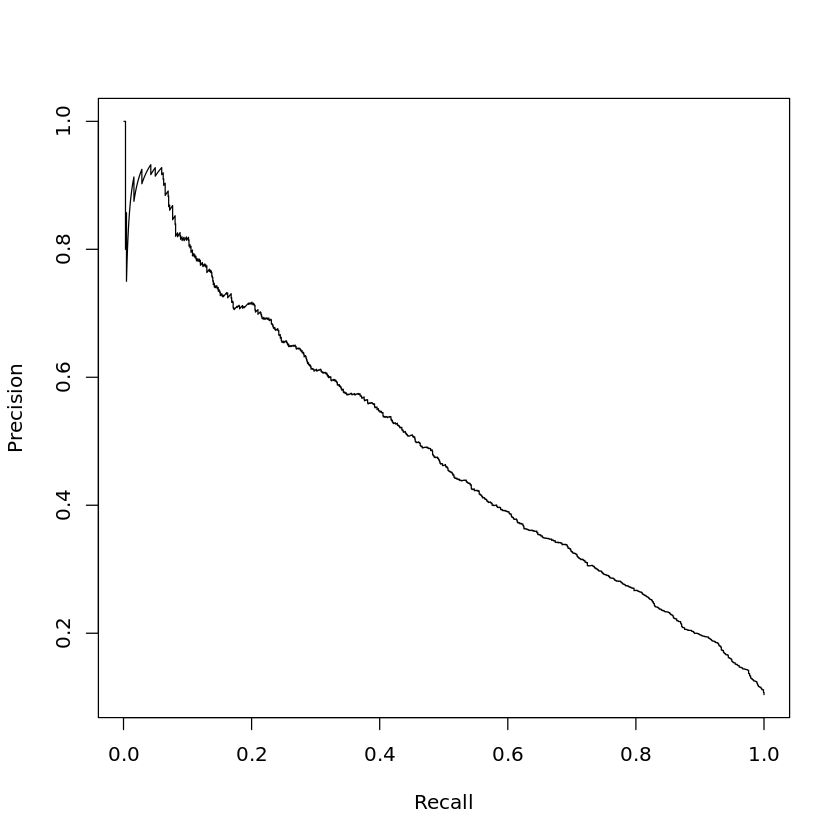

In [162]:
# get performance metrics AUC and PRC, at 24hr
options(repr.plot.width=7, repr.plot.height=7)

pred_rocr = ROCR::prediction(cohort_test$pred_death_24hr_recent, cohort_test$death_24hr_recent_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc #0.852746095933298 and 0.491112785165401

plot(ROC.perf)
plot(PRC.perf)

[1] 0.8506911

[1] 0.4816098

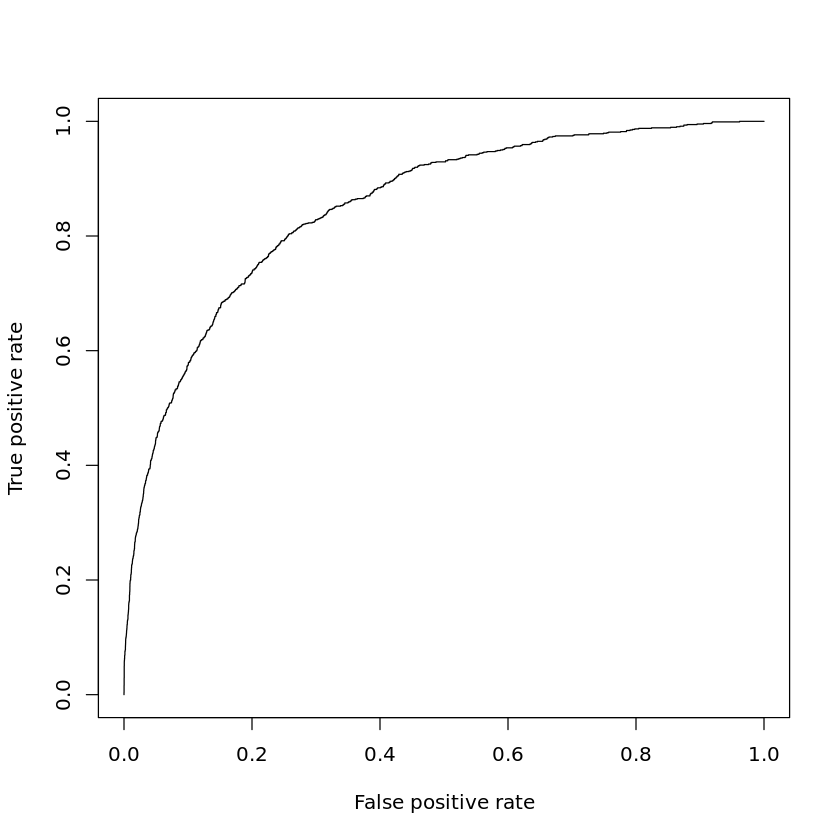

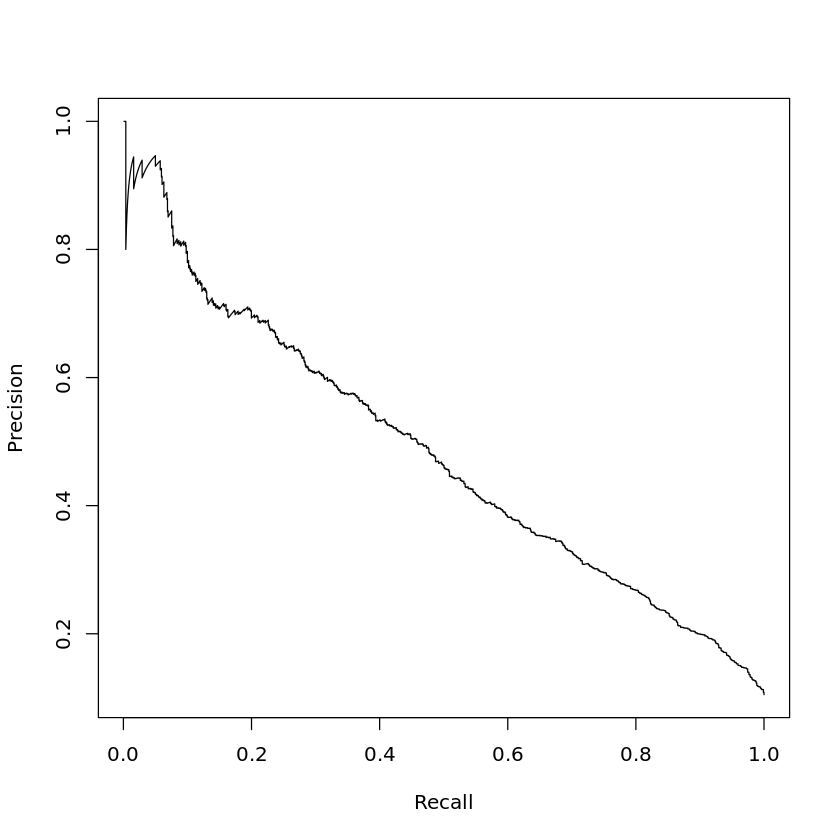

In [163]:
test2019 <- cohort_test %>% filter(adm_year==2019)
pred_rocr = ROCR::prediction(test2019$pred_death_24hr_recent, test2019$death_24hr_recent_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc #0.851396490675799 and 0.487723965329804

plot(ROC.perf)
plot(PRC.perf)

[1] 0.9085229

[1] 0.6442749

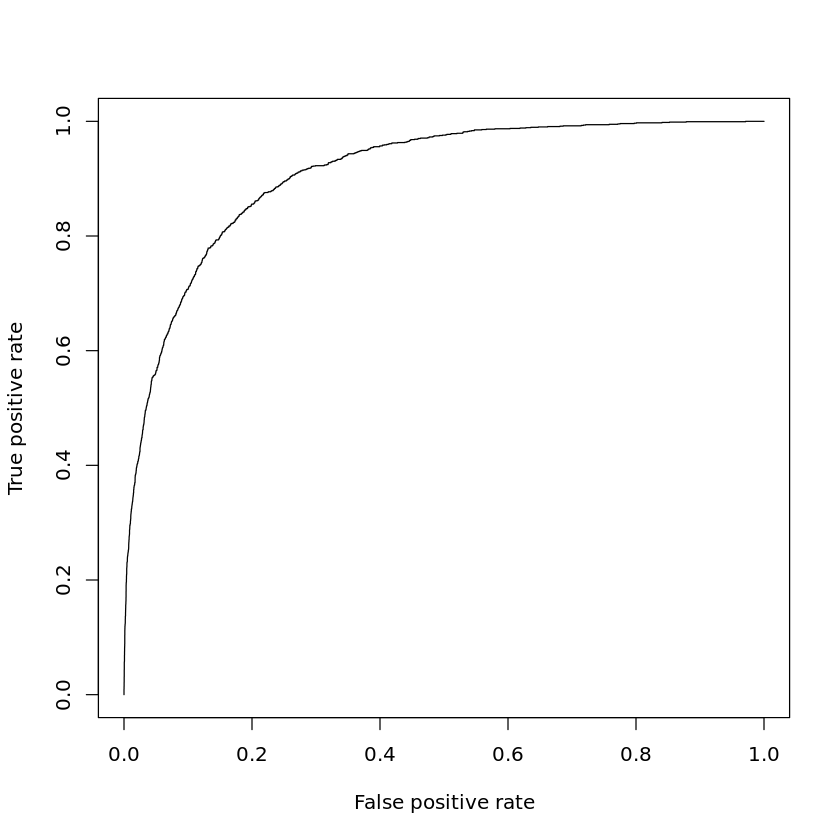

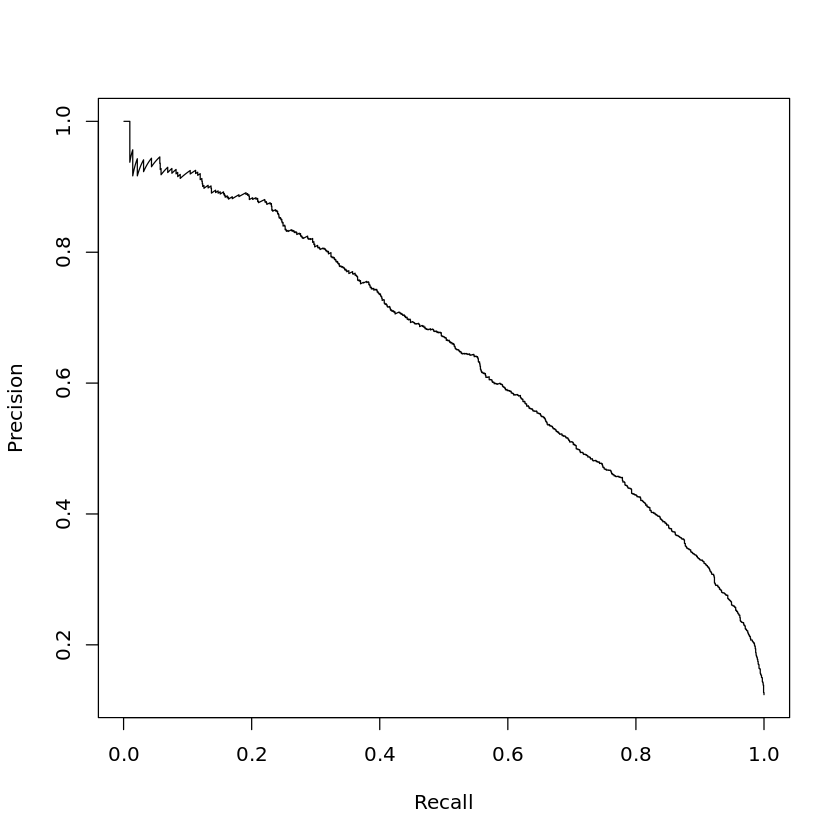

In [164]:
# get performance metrics AUC and PRC, and ACC
options(repr.plot.width=7, repr.plot.height=7)

pred_rocr = ROCR::prediction(cohort_test$pred_first, cohort_test$first_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc #0.907253499579289 and 0.642238742593756

plot(ROC.perf)
plot(PRC.perf)